In [ ]:
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
train_transformer = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
train_dataset = torchvision.datasets.CIFAR10(root='.', train=True, transform=train_transformer, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='.', train=False, transform=train_transformer, download=True)


100%|██████████| 170498071/170498071 [00:14<00:00, 12080743.60it/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [ ]:
print("dataset keys:",train_dataset.__dict__.keys())
print("dataset classes:", train_dataset.classes)
print("dataset data type:", type(train_dataset.data))
print("dataset target type:", type(train_dataset.targets))

dataset keys: dict_keys(['root', 'transform', 'target_transform', 'transforms', 'train', 'data', 'targets', 'classes', 'class_to_idx'])
dataset classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
dataset data type: <class 'numpy.ndarray'>
dataset target type: <class 'list'>


In [ ]:
batch_size = 128
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
dataloader = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
    'test': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
}

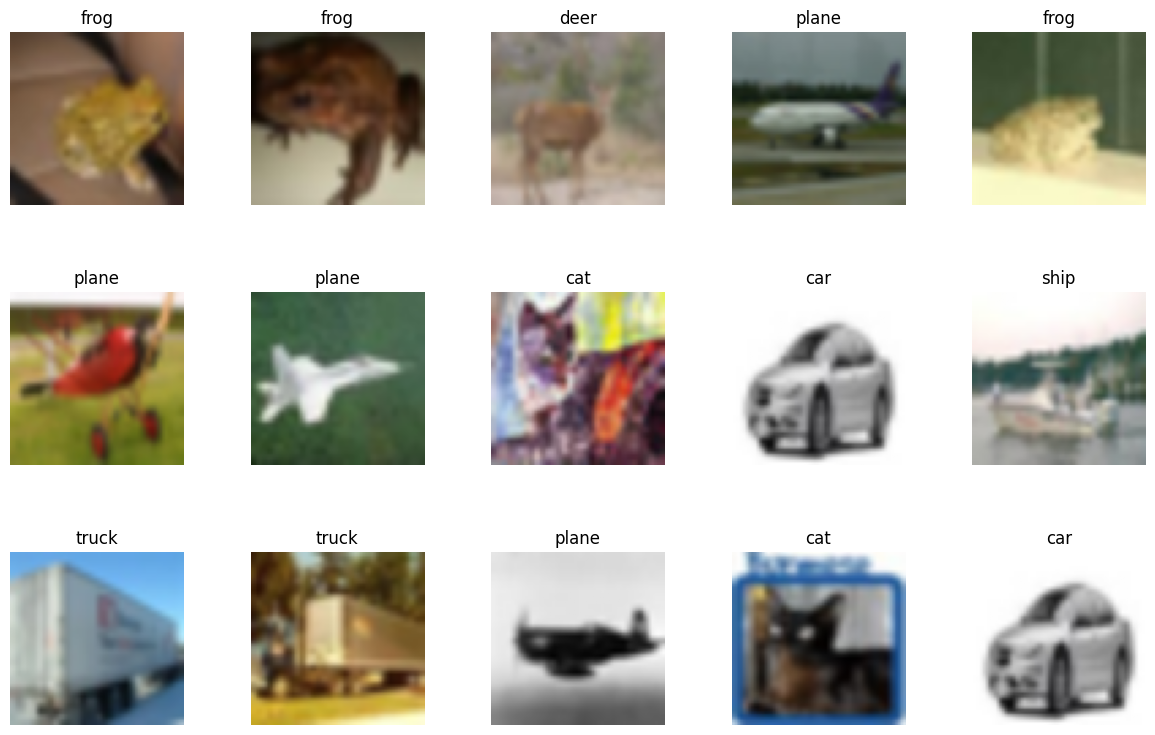

In [ ]:
# visualizción imágenes 

import random 
import matplotlib.pyplot as plt

r, c = 3, 5
plt.figure(figsize=(c*3, r*3))
for row in range(r):
    for col in range(c):
        index = c*row + col
        plt.subplot(r, c, index + 1)
        ix = random.randint(0, len(dataloader['train'])-1)
        img, label = train_dataset[ix]
        plt.imshow(img.permute(1, 2, 0))
        plt.axis('off')
        plt.title(classes[label])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [ ]:
import torch.nn as nn
import torch
def block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=5, stride=2, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=1)
    )

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = block(3, 64)
        self.conv2 = block(64, 128)
        self.conv3 = block(128, 256)
        #self.conv4 = block(256, 512)
        self.conv4=nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1)
        )
        
        self.fc = nn.Linear(512 * 3 * 3, 10)

    def forward(self, x):
        x = self.conv1(x)
        
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


$$ o = \lfloor \frac{n+2p-m}{s} \rfloor + 1 $$

Para las capas convolucionales, tienes los siguientes parámetros:

kernel_size = 5
padding = 0
stride = 2
Aplicando esta fórmula a la primera capa convolucional, tenemos:

output_size = (32 - 5 + 2*0)/2 + 1 = 14

 14x14 píxeles.

segunda capa

output_size = (14 - 5 + 2*0)/2 + 1 = 5

tercera capa 

output_size = (5 - 5 + 2*0)/2 + 1 = 1

cuarta capa tendremos un valor negativo 

output_size = (1 - 5 + 2*0)/2 + 1 = -1


In [ ]:
model = CNN()

In [ ]:
output = model(torch.randn(64, 3, 64, 64))

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=4608, out_features=10, bias=True)
)

In [ ]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=15):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")


In [ ]:
model = CNN()
fit(model, dataloader)

val_loss 1.38854 val_acc 0.48972: 100%|██████████| 79/79 [00:03<00:00, 20.20it/s]


Epoch 1/15 loss 1.68871 val_loss 1.38854 acc 0.36728 val_acc 0.48972


val_loss 1.18726 val_acc 0.57091: 100%|██████████| 79/79 [00:03<00:00, 20.48it/s]


Epoch 2/15 loss 1.29542 val_loss 1.18726 acc 0.53273 val_acc 0.57091


val_loss 1.08972 val_acc 0.61007: 100%|██████████| 79/79 [00:04<00:00, 17.42it/s]


Epoch 3/15 loss 1.13590 val_loss 1.08972 acc 0.59684 val_acc 0.61007


val_loss 1.02040 val_acc 0.64300: 100%|██████████| 79/79 [00:03<00:00, 20.54it/s]


Epoch 4/15 loss 1.01295 val_loss 1.02040 acc 0.64182 val_acc 0.64300


val_loss 0.99721 val_acc 0.65645: 100%|██████████| 79/79 [00:03<00:00, 19.91it/s]


Epoch 5/15 loss 0.90585 val_loss 0.99721 acc 0.68083 val_acc 0.65645


val_loss 0.98470 val_acc 0.65941: 100%|██████████| 79/79 [00:04<00:00, 17.48it/s]


Epoch 6/15 loss 0.80878 val_loss 0.98470 acc 0.71553 val_acc 0.65941


val_loss 0.99565 val_acc 0.66347: 100%|██████████| 79/79 [00:03<00:00, 20.31it/s]


Epoch 7/15 loss 0.69950 val_loss 0.99565 acc 0.75320 val_acc 0.66347


val_loss 1.00357 val_acc 0.67197: 100%|██████████| 79/79 [00:03<00:00, 19.88it/s]


Epoch 8/15 loss 0.59079 val_loss 1.00357 acc 0.79176 val_acc 0.67197


val_loss 1.16146 val_acc 0.66040: 100%|██████████| 79/79 [00:04<00:00, 17.17it/s]


Epoch 9/15 loss 0.48539 val_loss 1.16146 acc 0.82815 val_acc 0.66040


val_loss 1.18365 val_acc 0.66297: 100%|██████████| 79/79 [00:03<00:00, 20.23it/s]


Epoch 10/15 loss 0.38613 val_loss 1.18365 acc 0.86405 val_acc 0.66297


val_loss 1.27507 val_acc 0.65763: 100%|██████████| 79/79 [00:03<00:00, 20.40it/s]


Epoch 11/15 loss 0.29918 val_loss 1.27507 acc 0.89584 val_acc 0.65763


val_loss 1.51503 val_acc 0.64468: 100%|██████████| 79/79 [00:04<00:00, 17.33it/s]


Epoch 12/15 loss 0.23679 val_loss 1.51503 acc 0.91708 val_acc 0.64468


val_loss 1.77461 val_acc 0.65022: 100%|██████████| 79/79 [00:03<00:00, 20.01it/s]


Epoch 13/15 loss 0.19625 val_loss 1.77461 acc 0.93222 val_acc 0.65022


val_loss 1.89350 val_acc 0.64745: 100%|██████████| 79/79 [00:03<00:00, 20.20it/s]


Epoch 14/15 loss 0.15518 val_loss 1.89350 acc 0.94709 val_acc 0.64745


val_loss 1.83091 val_acc 0.65467: 100%|██████████| 79/79 [00:04<00:00, 17.24it/s]

Epoch 15/15 loss 0.15116 val_loss 1.83091 acc 0.94863 val_acc 0.65467


In [ ]:
# guardar modelo
PATH = './checkpoint_15.pt'
torch.save(model.state_dict(), PATH) 

In [ ]:
# cargar modelo
model_o= CNN()
model_o.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
import matplotlib.pyplot as plt

def plot_predictions(model, dataloader, r, c):
    model.to('cuda')
    with torch.no_grad():
        for loader_name, test_loader in dataloader.items():
            if loader_name == 'train':
                continue
            # Mostrar las primeras imágenes del primer lote del DataLoader de prueba
            fig = plt.figure(figsize=(2*c, 2*r))
            for batch_idx, (data, target) in enumerate(test_loader):
                if batch_idx == 0:
                    data = data.to('cuda')
                    target = target.to('cuda')
                    output = model(data)
                    predictions = output.argmax(dim=1)
                    for i in range(r * c):
                        plt.subplot(r, c, i + 1)
                        img = data[i].cpu().numpy().transpose(1, 2, 0)
                        y_true = target[i].item()
                        y_pred = predictions[i].item()
                        plt.imshow(img, cmap='gray')
                        plt.axis("off")
                        #plt.title(f"{y_true}/{y_pred}", color="green" if y_true == y_pred else "red")
                        plt.title(f"{classes[y_true]}/{classes[y_pred]}", color="green" if y_true == y_pred else "red")
                        plt.tight_layout()
                    plt.show()
                    break

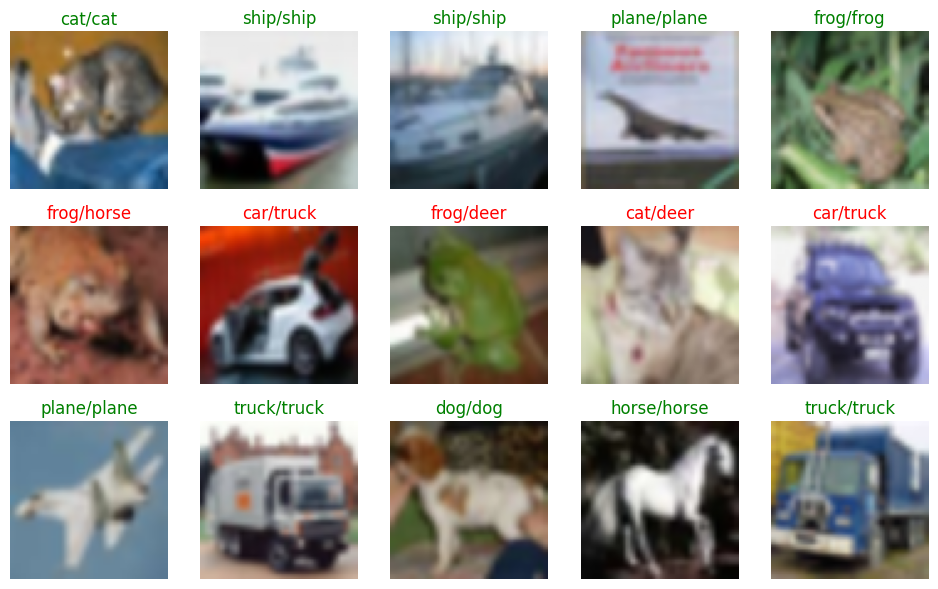

In [ ]:
plot_predictions(model, dataloader, 3, 5)